## Final Project: Major European Football Leagues Transfer Network

Data Source: https://github.com/d2ski/football-transfers-data/tree/main or https://www.kaggle.com/datasets/mexwell/football-transfer-dataset

### This project will investigate how major European football clubs are connected through player transfers, aiming to uncover market dynamics from 2009 to 2021.
##### **Goals of this project:**
1. I want to explore any particular connections between certain clubs, if there are any clubs that tend to buy and sell players to each other.
2. I want to look at how a player’s position (CF, RB, AM, etc) plays a factor in their transfer record.
3. I want to also explore how a player’s age and nationality affect where they’re transferred to.

##### **Dataset description:** 
There are 23 columns in this dataset. The most important information to my analysis include league (“league”), team transferred from, team transferred to (“team_name” and “counter_team_name”, direction determined by “dir”), team country (“team_country”), player age (“player_age”), player nationality (“player_nation”), player position (“player_pos”), and transfer fee amount (“transfer_fee_amnt”). Note that there are repeats of player transfers in this dataset, where one entry is “transferring to” and another entry is “transferring from” but both entries indicate the same event (they can be recognized by the same player name in the same season with two of the same team names). I will need to make sure not to duplicate those instances in my network. There are also missing data, I might want to exclude them or take the median or mode of other data.
##### **Here’s a specific description of each variable for reference:**
league - codename of the football league. Takes the following values:\
GB1: ENGLISH PREMIER LEAGUE\
ES1: LA LIGA\
IT1: SERIE A\
L1: BUNDESLIGA\
FR1: FRENCH LIGUE 1\
PO1: LIGA PORTUGAL BWIN\
NL1: DUTCH EREDIVISIE\
season - season\
window - transfer window (s summer or w winter)\
team_id - team's ID as used by Transfermarkt\
team_name - team's name\
team_country - team's country\
dir - transfer direction (in or left)\
player_id - player's ID as used by Transfermarkt\
player_name - player's name\
player_age - player's age when transfer occurred\
player_nation - player's nationality\
player_nation2 - player's 2nd nationality\
player_pos - player's field position\
counter_team_id - counter team's ID as used by Transfermarkt\
counter_team_name - counter team's name\
counter_team_country - counter team's country\
transfer_fee_amnt - transfer fee amount (EUR)\
market_val_amnt - player's market value (EUR) when transfer occurred estimated by Transfermarkt\
is_free - free transfer (True or False)\
is_loan - loan transfer (True or False)\
is_loan_end - end of loan transfer (True or False)\
is_retired - player retired (True or False)\
transfer_id - transfer's ID as used by Transfermarkt

##### **4 types of user interactions I want to create:**
1. Finding the most closely related nodes:\
*Which two clubs transfer players to each other most frequently?*

2. Providing a stat about a node of interest:\
*What player positions are most transferred into Bayern Munich over the years? What about positions transferred out?*

3. Finding specific information about edges:\
*What’s the average age of players transferred out of Manchester City versus players transferred in?*

4. Finding other information about edges:\
*What percentage of players transferred into La Liga clubs hold Spanish nationality? What about players transferred out of La Liga?*


### Below are the Python code execution for the above questions.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import community as community_louvain

In [15]:
# Set the figure size for matplotlib plots
plt.rcParams['figure.figsize'] = (12, 8)

#### Load and clean data:

In [16]:
def load_and_clean_data(file_path):
    """Load and clean transfers.csv."""
    print("Loading and cleaning data...")

    # Load the data
    df = pd.read_csv(file_path)

    # Handle missing values
    # For unknown player_age, fill with median age
    df['player_age'] = df['player_age'].fillna(df['player_age'].median())

    # For unknown player_nation, fill with 'Unknown'
    df['player_nation'] = df['player_nation'].fillna('Unknown')

    # For unknown transfer_fee_amnt, fill with 0 for free transfers and median for others
    df.loc[df['is_free'], 'transfer_fee_amnt'] = 0
    median_fee = df[df['transfer_fee_amnt'].notna() & (~df['is_free'])]['transfer_fee_amnt'].median()
    df['transfer_fee_amnt'] = df['transfer_fee_amnt'].fillna(median_fee)

    # Convert transfer_fee_amnt to millions for better readability
    df['transfer_fee_millions'] = df['transfer_fee_amnt'] / 1000000

    # Create a unique identifier for each transfer to avoid duplicates
    df['transfer_key'] = df.apply(
        lambda x: f"{x['player_id']}_{x['season']}_{x['window']}_{x['team_id']}_{x['counter_team_id']}",
        axis=1
    )

    # Keep only relevant columns for our analysis
    relevant_columns = [
        'league', 'season', 'window', 'team_name', 'team_country', 'dir',
        'player_name', 'player_age', 'player_nation', 'player_pos',
        'counter_team_name', 'counter_team_country', 'transfer_fee_millions',
        'is_free', 'is_loan', 'transfer_key'
    ]

    df = df[relevant_columns]

    # Filter out duplicate transfers (ie. same event recorded twice)
    # Keep only 'in' transfer direction to avoid double counting
    df_in = df[df['dir'] == 'in'].copy()

    print(f"Data loaded and cleaned. {len(df_in)} unique transfers after cleaning.")

    return df, df_in

#### Create network graphs and visualize them:

In [17]:
def create_network_graph(df_in):
    """Create a network graph from transfer.csv."""
    print("Creating network graph...")

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (teams)
    all_teams = set(df_in['team_name'].tolist() + df_in['counter_team_name'].tolist())
    for team in all_teams:
        G.add_node(team)

    # Add edges (transfers)
    for _, row in df_in.iterrows():
        source = row['counter_team_name']  # From team
        target = row['team_name']          # To team

        # Check if edge already exists
        if G.has_edge(source, target):
            # Increment weight
            G[source][target]['weight'] += 1
            G[source][target]['transfers'].append({
                'player': row['player_name'],
                'season': row['season'],
                'fee': row['transfer_fee_millions'],
                'age': row['player_age'],
                'position': row['player_pos'],
                'nationality': row['player_nation']
            })
        else:
            # Create new edge if edge doesn't exist
            G.add_edge(source, target, weight=1, transfers=[{
                'player': row['player_name'],
                'season': row['season'],
                'fee': row['transfer_fee_millions'],
                'age': row['player_age'],
                'position': row['player_pos'],
                'nationality': row['player_nation']
            }])

    print(f"Network graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

##### Network visualization of all nodes and edges:

In [18]:
def visualize_network(G, title="Football Transfer Network"):
    """Create a visualization of the transfer network and save it as PNG."""
    print("Generating network visualization...")

    # Calculate node sizes based on degree centrality
    degrees = dict(G.degree())
    node_sizes = {node: (degrees[node] * 3) + 10 for node in G.nodes()}

    # Use spring layout for node positions
    pos = nx.spring_layout(G, seed=42)

    # Create a matplotlib figure
    plt.figure(figsize=(20, 16))

    # Draw the network
    # Draw nodes with size based on degree
    node_list = list(G.nodes())
    node_size = [node_sizes[node] for node in node_list]
    node_color = [degrees[node] for node in node_list]

    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                  nodelist=node_list,
                                  node_size=node_size,
                                  node_color=node_color,
                                  cmap=plt.cm.YlGnBu)

    # Add a colorbar
    plt.colorbar(nodes, label='Number of Connections')

    # Draw labels for nodes with high degree
    high_degree_nodes = [node for node, degree in degrees.items() if degree > 30]
    nx.draw_networkx_labels(G, pos,
                           {node: node for node in high_degree_nodes},
                           font_size=8,
                           font_color='black')

    plt.title(title, fontsize=20)
    plt.axis('off')

    # Save the figure as PNG
    output_file = 'transfer_network.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Network visualization saved to {output_file}")

##### Network visualization of:
1. Strong connections (weight of edges >= 10) in circular layout. Weight of edges are detemrined by number of transfers between clubs
2. Top 30 most connected clubs (meaning these clubs are overall most active on the transfer market, but they aren't necessarily connected with each other)

In [19]:
# Create improved visualizations of strong connections
def create_improved_strong_network(G, degrees, threshold=10):
    """Create an improved visualization of the strongest connections in the network."""
    print("Creating improved visualization of strong connections...")

    # Create a subgraph with only the most connected edges
    strong_edges = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= threshold]
    G_strong = G.edge_subgraph(strong_edges)

    # Remove isolated nodes (nodes with no connections)
    G_strong = G_strong.copy()
    isolated_nodes = [node for node, degree in dict(G_strong.degree()).items() if degree == 0]
    G_strong.remove_nodes_from(isolated_nodes)

    # Try to detect communities to color nodes
    try:
        # Use Louvain community detection
        communities = community_louvain.best_partition(G_strong.to_undirected())

        # Get unique community IDs
        community_ids = set(communities.values())
        print(f"Detected {len(community_ids)} communities in the strong network")

        # Create a colormap for communities
        cmap = plt.cm.get_cmap('tab20', len(community_ids))
        node_colors = [cmap(communities[node]) for node in G_strong.nodes()]
    except Exception as e:
        # If community detection fails, use degree for coloring
        print(f"Community detection failed: {e}. Using degree for coloring instead.")
        node_colors = [degrees[node] for node in G_strong.nodes()]

    # Create visualizations for circular layout
    layouts = {'circular': nx.circular_layout}

    for layout_name, layout_func in layouts.items():
        plt.figure(figsize=(20, 16))

        # Use the specified layout
        pos = layout_func(G_strong)

        # Draw edges with alpha based on weight
        edge_weights = [G_strong[u][v]['weight'] for u, v in G_strong.edges()]
        max_weight = max(edge_weights) if edge_weights else 1
        edge_alphas = [(w / max_weight) * 0.8 + 0.2 for w in edge_weights]

        # Draw edges
        for i, (u, v) in enumerate(G_strong.edges()):
            nx.draw_networkx_edges(G_strong, pos, edgelist=[(u, v)],
                                  width=1.5, alpha=edge_alphas[i],
                                  edge_color='gray')

        # Draw nodes with size based on degree
        node_list = list(G_strong.nodes())
        node_size = [degrees[node] * 2 for node in node_list]

        # Draw nodes
        nx.draw_networkx_nodes(G_strong, pos,
                              nodelist=node_list,
                              node_size=node_size,
                              node_color=node_colors,
                              alpha=0.8)

        # Draw labels with better visibility
        # Adjust label positions slightly to avoid overlap with nodes
        label_pos = {node: (pos[node][0], pos[node][1] + 0.02) for node in pos}

        # Only label nodes with significant connections
        significant_nodes = [node for node in G_strong.nodes() if degrees[node] >= 15]
        nx.draw_networkx_labels(G_strong, label_pos,
                               {node: node for node in significant_nodes},
                               font_size=10, font_weight='bold',
                               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

        plt.title(f"Top Transfer Connections (≥{threshold} transfers) - {layout_name.replace('_', ' ').title()} Layout",
                 fontsize=16)
        plt.axis('off')

        # Save the figure as PNG
        output_file = f'transfer_network_strong_{layout_name}.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()

        print(f"Strong connections visualization with {layout_name} layout saved to {output_file}")

    # Create a special circular layout for top 30 clubs
    plt.figure(figsize=(22, 18))

    # Identify top 30 clubs by degree
    top_clubs = sorted([(node, degrees[node]) for node in G_strong.nodes()],
                      key=lambda x: x[1], reverse=True)[:30]
    top_club_names = [club[0] for club in top_clubs]

    # Create a subgraph of just the top 30 clubs
    G_top = G_strong.subgraph(top_club_names)

    # Use circular layout for top 30 clubs
    pos_top = nx.circular_layout(G_top, scale=10)

    # Draw edges with width based on weight
    for u, v, data in G_top.edges(data=True):
        width = data['weight'] / 5  # Scale down for better visibility
        nx.draw_networkx_edges(G_top, pos_top, edgelist=[(u, v)],
                              width=width, alpha=0.6,
                              edge_color='gray')

    # Draw nodes
    nx.draw_networkx_nodes(G_top, pos_top,
                          node_size=[degrees[node] * 3 for node in G_top.nodes()],
                          node_color='skyblue',
                          alpha=0.8)

    # Draw labels
    nx.draw_networkx_labels(G_top, pos_top,
                           {node: node for node in G_top.nodes()},
                           font_size=12, font_weight='bold',
                           bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

    # Add edge labels (number of transfers)
    edge_labels = {(u, v): data['weight'] for u, v, data in G_top.edges(data=True)}
    nx.draw_networkx_edge_labels(G_top, pos_top, edge_labels=edge_labels,
                                font_size=10, font_color='red')

    plt.title("Top 30 Clubs Transfer Network", fontsize=20)
    plt.axis('off')

    # Save the figure as PNG
    output_file = 'transfer_network_top30_clubs.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Top 30 clubs visualization saved to {output_file}")

##### Find the most connected clubs to answer my first question: Which two clubs transfer players to each other most frequently?

In [20]:
def find_most_connected_clubs(G):
    """Find the two clubs that transfer players to each other most frequently."""
    print("\n1. Finding the most closely related nodes (clubs)...")

    max_weight = 0
    most_connected_pair = None

    for u, v, data in G.edges(data=True):
        if data['weight'] > max_weight:
            max_weight = data['weight']
            most_connected_pair = (u, v)

    if most_connected_pair:
        club1, club2 = most_connected_pair
        print(f"The clubs that transfer players most frequently are: {club1} and {club2}")
        print(f"They have transferred {max_weight} players between them.")

        # Get details of the transfers
        transfers = G[club1][club2]['transfers']
        print(f"\nDetails of transfers from {club1} to {club2}:")
        for i, t in enumerate(transfers[:5], 1):  # Show first 5 transfers
            print(f"  {i}. {t['player']} ({t['position']}) in {t['season']} for €{t['fee']:.2f}M")

        if len(transfers) > 5:
            print(f"  ... and {len(transfers) - 5} more transfers.")

        # Check if there are transfers in the opposite direction
        if G.has_edge(club2, club1):
            reverse_transfers = G[club2][club1]['transfers']
            print(f"\nTransfers from {club2} to {club1}: {len(reverse_transfers)}")
            for i, t in enumerate(reverse_transfers[:5], 1):  # Show first 5 transfers
                print(f"  {i}. {t['player']} ({t['position']}) in {t['season']} for €{t['fee']:.2f}M")

            if len(reverse_transfers) > 5:
                print(f"  ... and {len(reverse_transfers) - 5} more transfers.")

        return club1, club2, max_weight
    else:
        print("No connected clubs found.")
        return None, None, 0

##### Find out player position to answer my second question: What player positions are most transferred into Bayern Munich over the years? What about position transferred out?
Note that the code can be changed to any other club.

In [21]:
def analyze_positions_for_club(G, club_name):
    """Analyze the positions of players transferred in and out of a specific club."""
    print(f"\n2. Analyzing player positions for {club_name}...")
    
    # Positions transferred in
    positions_in = []
    for u, v, data in G.edges(data=True):
        if v == club_name:  # Transfers into the club
            for transfer in data['transfers']:
                positions_in.append(transfer['position'])
    
    # Positions transferred out
    positions_out = []
    for u, v, data in G.edges(data=True):
        if u == club_name:  # Transfers out of the club
            for transfer in data['transfers']:
                positions_out.append(transfer['position'])
    
    # Count frequencies
    pos_in_count = Counter(positions_in)
    pos_out_count = Counter(positions_out)
    
    # Print results
    print(f"\nPositions transferred INTO {club_name}:")
    for pos, count in pos_in_count.most_common():
        print(f"  {pos}: {count} players ({count/len(positions_in)*100:.1f}%)")
    
    print(f"\nPositions transferred OUT OF {club_name}:")
    for pos, count in pos_out_count.most_common():
        print(f"  {pos}: {count} players ({count/len(positions_out)*100:.1f}%)")
    
    # Create a combined dataframe for visualization
    # Get all unique positions
    all_positions = sorted(set(list(pos_in_count.keys()) + list(pos_out_count.keys())))
    
    # Create dataframe
    data = {
        'Position': all_positions,
        'Transfers In': [pos_in_count.get(pos, 0) for pos in all_positions],
        'Transfers Out': [pos_out_count.get(pos, 0) for pos in all_positions]
    }
    df = pd.DataFrame(data)
    
    # Sort by total transfers
    df['Total'] = df['Transfers In'] + df['Transfers Out']
    df = df.sort_values('Total', ascending=False)
    
    # Create side-by-side bar chart
    plt.figure(figsize=(14, 8))
    
    # Set the width of the bars
    bar_width = 0.35
    
    # Set the positions of the bars on the x-axis
    r1 = np.arange(len(df))
    r2 = [x + bar_width for x in r1]
    
    # Create the bars
    plt.bar(r1, df['Transfers In'], color='blue', width=bar_width, edgecolor='grey', label='Transfers In')
    plt.bar(r2, df['Transfers Out'], color='red', width=bar_width, edgecolor='grey', label='Transfers Out')
    
    # Add labels and title
    plt.xlabel('Position', fontweight='bold', fontsize=12)
    plt.ylabel('Number of Players', fontweight='bold', fontsize=12)
    plt.title(f'Player Positions Transferred In and Out of {club_name}', fontweight='bold', fontsize=14)
    
    # Add xticks on the middle of the group bars
    plt.xticks([r + bar_width/2 for r in range(len(df))], df['Position'])
    
    # Add a legend
    plt.legend()
    
    # Add value labels on top of each bar
    for i, v in enumerate(df['Transfers In']):
        if v > 0:
            plt.text(i - 0.05, v + 0.5, str(v), color='blue', fontweight='bold')
    
    for i, v in enumerate(df['Transfers Out']):
        if v > 0:
            plt.text(i + bar_width - 0.05, v + 0.5, str(v), color='red', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{club_name.replace(" ", "_")}_positions.png')
    print(f"Position analysis for {club_name} saved to {club_name.replace(' ', '_')}_positions.png")
    
    return pos_in_count, pos_out_count

##### Find out specific information about edges to answer my third question: What’s the average age of players transferred out of Manchester City versus players transferred in?

In [22]:
def analyze_player_ages(G, club_name):
    """Analyze the ages of players transferred in and out of a specific club."""
    print(f"\n3. Analyzing player ages for {club_name}...")
    
    # Ages of players transferred in
    ages_in = []
    for u, v, data in G.edges(data=True):
        if v == club_name:  # Transfers into the club
            for transfer in data['transfers']:
                ages_in.append(transfer['age'])
    
    # Ages of players transferred out
    ages_out = []
    for u, v, data in G.edges(data=True):
        if u == club_name:  # Transfers out of the club
            for transfer in data['transfers']:
                ages_out.append(transfer['age'])
    
    # Calculate statistics
    avg_age_in = np.mean(ages_in)
    avg_age_out = np.mean(ages_out)
    
    print(f"\nAverage age of players transferred INTO {club_name}: {avg_age_in:.2f} years")
    print(f"Average age of players transferred OUT OF {club_name}: {avg_age_out:.2f} years")
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Histogram for ages transferred in
    ax1.hist(ages_in, bins=range(15, 41), color='blue', alpha=0.7)
    ax1.axvline(avg_age_in, color='red', linestyle='dashed', linewidth=2)
    ax1.text(avg_age_in + 0.5, max(ax1.get_ylim()) * 0.9, f'Avg: {avg_age_in:.2f}', color='red')
    ax1.set_title(f'Ages of Players Transferred INTO {club_name}')
    ax1.set_xlabel('Age')
    ax1.set_ylabel('Number of Players')
    
    # Histogram for ages transferred out
    ax2.hist(ages_out, bins=range(15, 41), color='red', alpha=0.7)
    ax2.axvline(avg_age_out, color='blue', linestyle='dashed', linewidth=2)
    ax2.text(avg_age_out + 0.5, max(ax2.get_ylim()) * 0.9, f'Avg: {avg_age_out:.2f}', color='blue')
    ax2.set_title(f'Ages of Players Transferred OUT OF {club_name}')
    ax2.set_xlabel('Age')
    ax2.set_ylabel('Number of Players')
    
    plt.tight_layout()
    plt.savefig(f'{club_name.replace(" ", "_")}_ages.png')
    print(f"Age analysis for {club_name} saved to {club_name.replace(' ', '_')}_ages.png")
    
    return avg_age_in, avg_age_out

##### Find out more information about edges: What percentage of players transferred into La Liga clubs hold Spanish nationality? What about players transferred out of La Liga?

In [23]:
def analyze_nationality_by_league(G, df, league_code):
    """Analyze the nationality of players transferred in and out of a specific league."""
    print(f"\n4. Analyzing player nationalities for league code {league_code}...")
    
    # Get league name
    league_name = {
        'GB1': 'English Premier League',
        'ES1': 'La Liga',
        'IT1': 'Serie A',
        'L1': 'Bundesliga',
        'FR1': 'French Ligue 1',
        'PO1': 'Liga Portugal Bwin',
        'NL1': 'Dutch Eredivisie'
    }.get(league_code, league_code)
    
    # Get teams in the league
    league_teams = set(df[df['league'] == league_code]['team_name'])
    
    # Nationalities of players transferred in
    nations_in = []
    for u, v, data in G.edges(data=True):
        if v in league_teams:  # Transfers into a league team
            for transfer in data['transfers']:
                nations_in.append(transfer['nationality'])
    
    # Nationalities of players transferred out
    nations_out = []
    for u, v, data in G.edges(data=True):
        if u in league_teams:  # Transfers out of a league team
            for transfer in data['transfers']:
                nations_out.append(transfer['nationality'])
    
    # Get the main nationality of the league's country
    league_country = {
        'GB1': 'England',
        'ES1': 'Spain',
        'IT1': 'Italy',
        'L1': 'Germany',
        'FR1': 'France',
        'PO1': 'Portugal',
        'NL1': 'Netherlands'
    }.get(league_code)
    
    # Calculate percentage of local nationality
    local_nationality_in = nations_in.count(league_country) / len(nations_in) * 100 if nations_in else 0
    local_nationality_out = nations_out.count(league_country) / len(nations_out) * 100 if nations_out else 0
    
    print(f"\nPercentage of {league_country} players transferred INTO {league_name}: {local_nationality_in:.2f}%")
    print(f"Percentage of {league_country} players transferred OUT OF {league_name}: {local_nationality_out:.2f}%")
    
    # Count frequencies
    nations_in_count = Counter(nations_in)
    nations_out_count = Counter(nations_out)
    
    # Get top 10 nationalities
    top_nations_in = nations_in_count.most_common(10)
    top_nations_out = nations_out_count.most_common(10)
    
    print(f"\nTop 10 nationalities transferred INTO {league_name}:")
    for nation, count in top_nations_in:
        print(f"  {nation}: {count} players ({count/len(nations_in)*100:.1f}%)")
    
    print(f"\nTop 10 nationalities transferred OUT OF {league_name}:")
    for nation, count in top_nations_out:
        print(f"  {nation}: {count} players ({count/len(nations_out)*100:.1f}%)")
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot for top nationalities transferred in
    nations_in_df = pd.DataFrame(top_nations_in, columns=['Nation', 'Count'])
    ax1.barh(nations_in_df['Nation'], nations_in_df['Count'], color='blue', alpha=0.7)
    ax1.set_title(f'Top 10 Nationalities Transferred INTO {league_name}')
    ax1.set_xlabel('Number of Players')
    ax1.set_ylabel('Nationality')
    
    # Plot for top nationalities transferred out
    nations_out_df = pd.DataFrame(top_nations_out, columns=['Nation', 'Count'])
    ax2.barh(nations_out_df['Nation'], nations_out_df['Count'], color='red', alpha=0.7)
    ax2.set_title(f'Top 10 Nationalities Transferred OUT OF {league_name}')
    ax2.set_xlabel('Number of Players')
    ax2.set_ylabel('Nationality')
    
    plt.tight_layout()
    plt.savefig(f'{league_code}_nationalities.png')
    print(f"Nationality analysis for {league_name} saved to {league_code}_nationalities.png")
    
    return local_nationality_in, local_nationality_out

##### Define main function for final outputs:

Loading and cleaning data...
Data loaded and cleaned. 31934 unique transfers after cleaning.
Creating network graph...
Network graph created with 2631 nodes and 17714 edges.
Generating network visualization...
Network visualization saved to transfer_network.png

1. Finding the most closely related nodes (clubs)...
The clubs that transfer players most frequently are: FC Stade Rennes B and Stade Rennais FC
They have transferred 47 players between them.

Details of transfers from FC Stade Rennes B to Stade Rennais FC:
  1. Maxime Le Marchand (CB) in 2009 for €2.20M
  2. Abdoul Camara (LW) in 2009 for €2.20M
  3. Florent Petit (GK) in 2009 for €2.20M
  4. Yacine Brahimi (LW) in 2009 for €2.20M
  5. Abdoulaye Diallo (GK) in 2009 for €2.20M
  ... and 42 more transfers.

2. Analyzing player positions for Bayern Munich...

Positions transferred INTO Bayern Munich:
  CB: 24 players (19.2%)
  CM: 21 players (16.8%)
  CF: 14 players (11.2%)
  DM: 14 players (11.2%)
  GK: 13 players (10.4%)
  AM: 

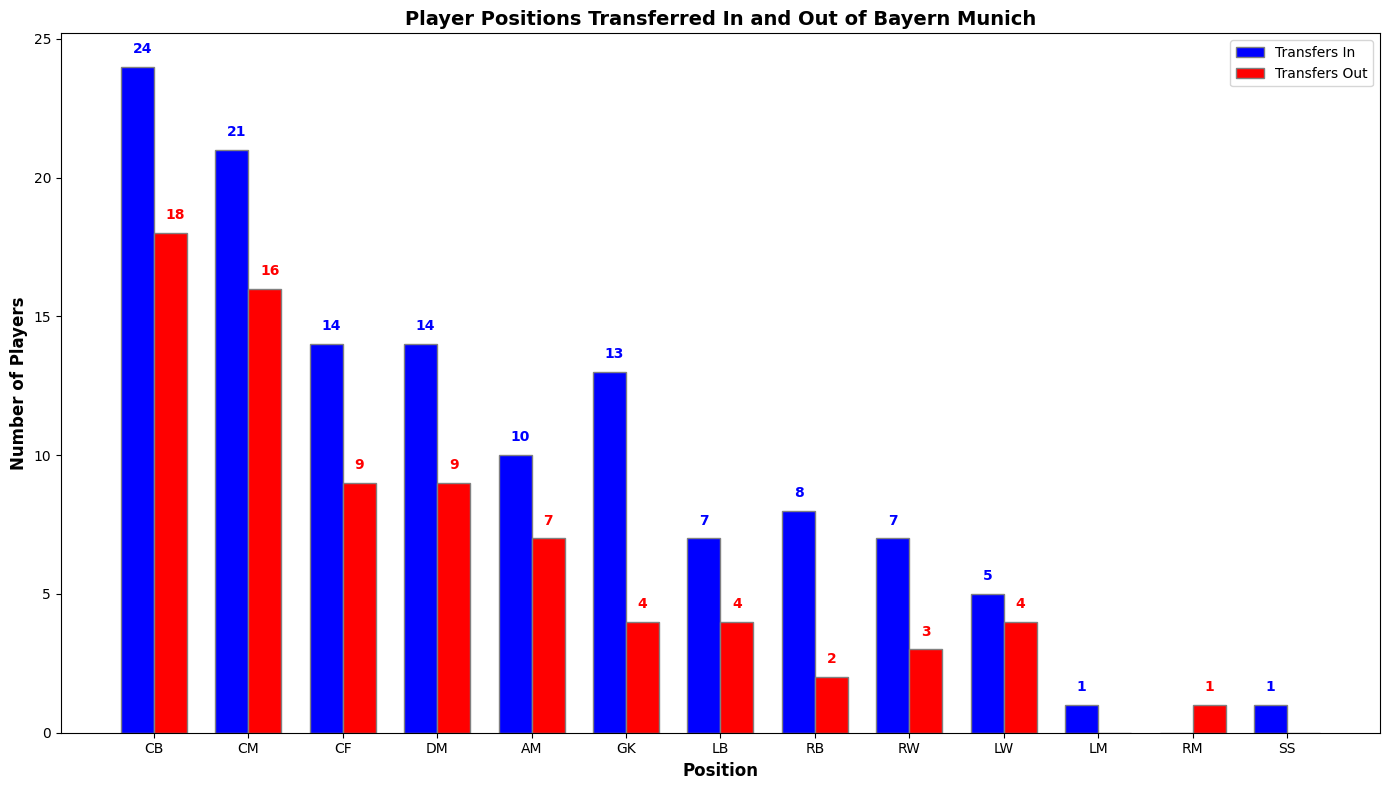

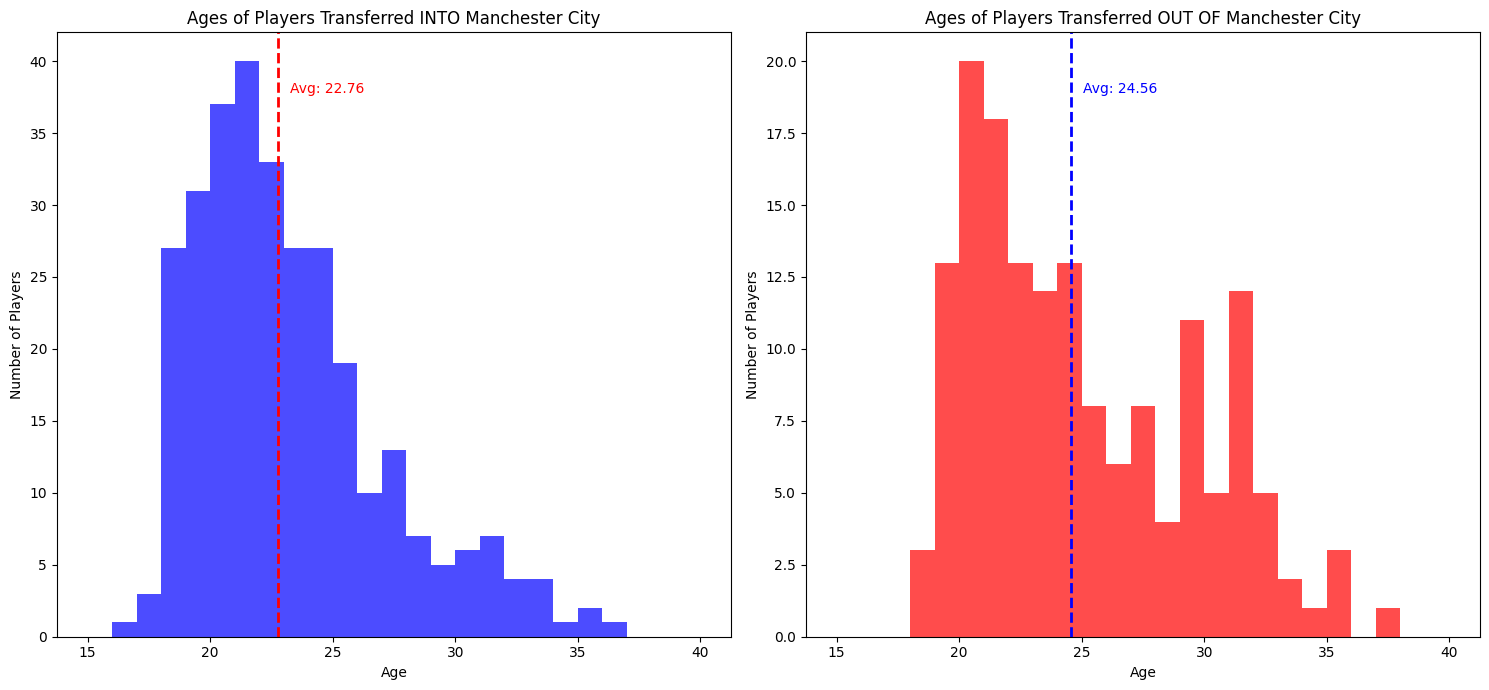

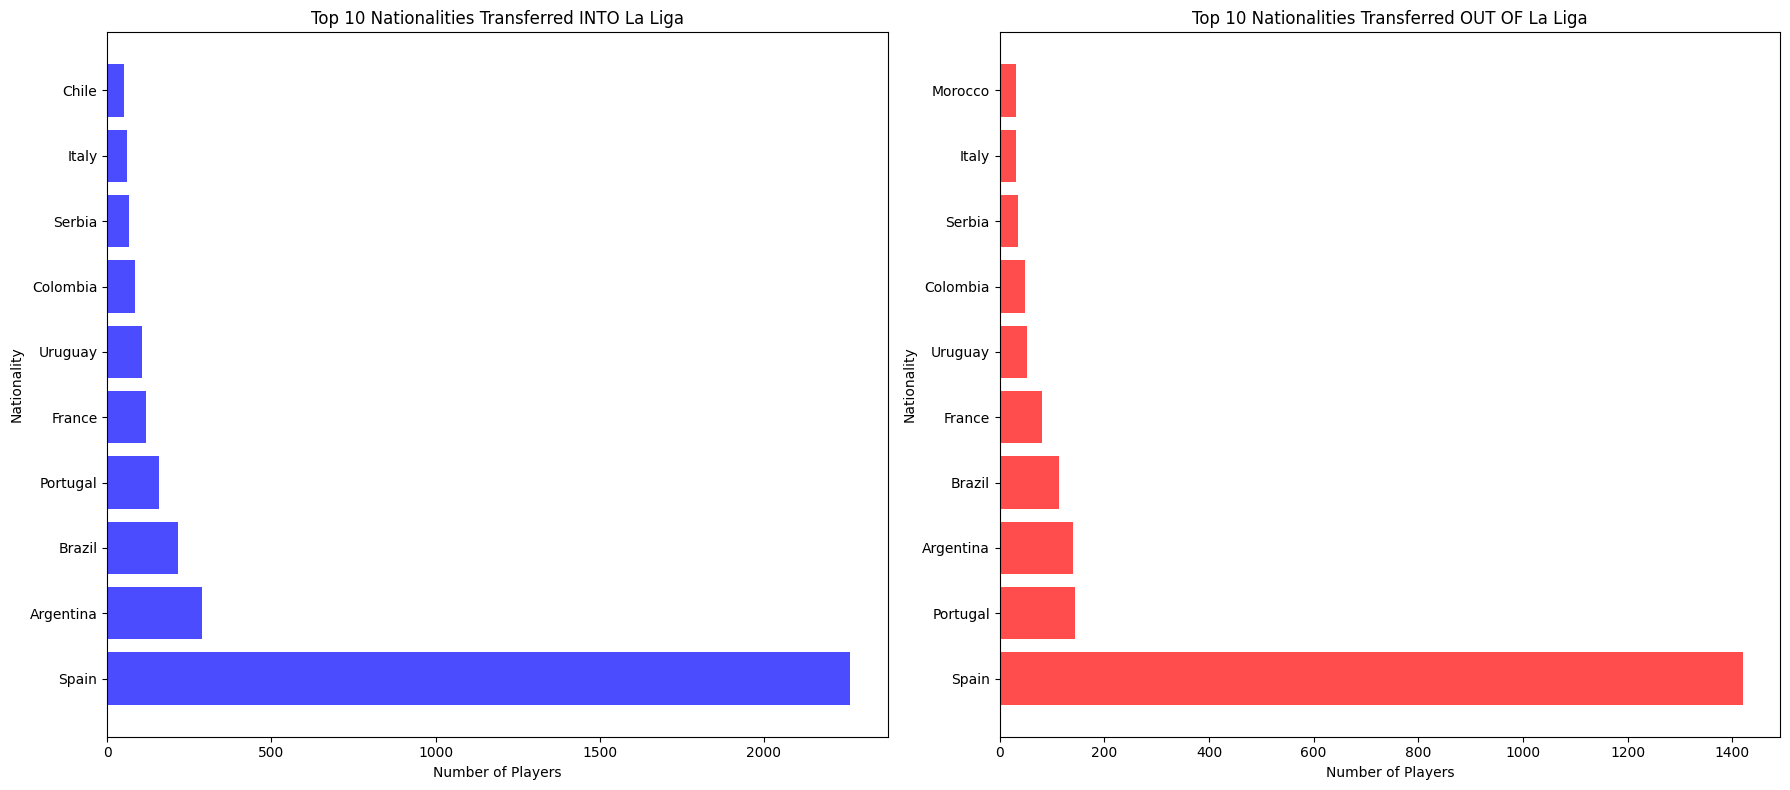

In [26]:
def main():
    # Load and clean data
    df, df_in = load_and_clean_data('transfers.csv')
    
    # Create network graph
    G = create_network_graph(df_in)
    
    # Visualize network
    visualize_network(G)
    
    # Answer the 4 questions
    
    # 1. Which two clubs transfer players to each other most frequently?
    club1, club2, max_weight = find_most_connected_clubs(G)
    
    # 2. What player positions are most transferred into Bayern Munich over the years? What about positions transferred out?
    analyze_positions_for_club(G, "Bayern Munich")
    
    # 3. What's the average age of players transferred out of PSG versus players transferred in?
    analyze_player_ages(G, "Manchester City")
    
    # 4. What percentage of players transferred into La Liga clubs hold Spanish nationality? What about players transferred out of La Liga?
    analyze_nationality_by_league(G, df, "ES1")
    
    print("\nAnalysis complete! Check the current directory for visualization files.")

if __name__ == "__main__":
    main()